In [1]:
#imports
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
from brainglobe_atlasapi.bg_atlas import BrainGlobeAtlas
from brainrender import Scene
from brainrender.actors import Neuron

In [8]:
#function definitions
def drop_by_thresh(df, thresh):
    '''
    this is written to drop columns of a data frame that have a sum value of below the input threshold
    df: pandas.DataFrame
    thresh: float
    returns: pandas.DataFrame
    '''
    sum_df = df.apply(np.sum, axis=0)
    mask = sum_df < thresh
    low_endpoint_regions = sum_df[mask].index
    return df.drop(low_endpoint_regions, axis=1)

def load_data_from_dir(direct):
    '''
    load data from a directory into a pandas DataFrame, replaces NaNs with 0s for the purpose of this notebook
    dir: string
    returns: pandas.DataFram
    '''
    data = pd.DataFrame()
    print('Loading files:')
    for file in tqdm(os.listdir(direct)):
        filename = os.path.join(direct, file)
        df = pd.read_csv(filename, header=None)
        df[0] = df[0] + df[1]
        df[1] = df[2]
        del df[2]
        df = df.loc[(df!=0).any(axis=1)]
        df_t = df.transpose()
        file = file.replace('_freq.csv','')
        file = file.replace('_length.csv', '')
        df_t = df_t.rename(index={1: file})
        df_t.columns = df_t.iloc[0]
        df_t = df_t.drop([0])
        data = pd.concat([data, df_t], join='outer')
    data_nonan = data.replace(np.nan, 0)
    return data_nonan

def preprocess(df):
    '''
    preprocess data however I want to, accepts a pandas.DataFrame with no NaNs
    df: pandas.DataFrame
    returns: pandas.DataFrame
    '''
    #remove zero variance columns
    selector = VarianceThreshold(threshold=0.0).set_output(transform='pandas')
    df = selector.fit_transform(df)
    
    #filter out regions that have less than 3 endpoints labeled in that region
    data_thresh = drop_by_thresh(df, 3)
    data_toln = data_thresh.copy()

    #natural log scale my data, formula of ln(number of terminals + 1) as per Ding et al. 2025
    for i, row in data_toln.iterrows():
        data_toln.loc[i] = row.map(lambda x: np.log(x+1))

    return data_toln

def cluster_and_plot(df, **plot_info):
    '''
    hierarchically cluster and plot data using seaborn.clustermap using euclidean distance with ward's linkage
    df: pandas.DataFrame
    plot_info: matplotlib kwargs
    returns: None
    '''
    
    cmap = sns.clustermap(df, 
                  method='ward', 
                  metric='euclidean', 
                  row_cluster=False,
                  dendrogram_ratio=(.1, .15),
                  cbar_pos=(0, .15, .03, .7),
                  cbar_kws={'label': 'ln(terminals in region + 1)'},
                  yticklabels=True,
                  xticklabels=True)
    
    return cmap

In [3]:
#import allen atlas
ccf_v3_10mic = BrainGlobeAtlas('allen_mouse_10um')

In [15]:
#data input
#on my PC in lab dir is C:\Users\samkr\OneDrive\Documents\Code\reconstructions\SNT_histos\SNT_histos\frequency 
#on shared PC its ...
frequency_dir = input('Input directory with region frequency data: ') #C:\Users\samkr\OneDrive\Documents\Code\reconstructions\SNT_histos\SNT_histos\frequency
length_dir = input('Input directory with region length data: ') #C:\Users\samkr\OneDrive\Documents\Code\reconstructions\SNT_histos\SNT_histos\length

In [16]:
#load frequency and length data in
frequency_data = load_data_from_dir(frequency_dir)
length_data = load_data_from_dir(length_dir)
#print("Column variances:", np.var(data, axis=0))

Loading files:


100%|██████████| 52/52 [00:00<00:00, 56.58it/s]
C:\Users\samkr\AppData\Local\Temp\ipykernel_50344\3075637224.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_nonan = data.replace(np.nan, 0)


Loading files:


100%|██████████| 52/52 [00:01<00:00, 44.36it/s]
C:\Users\samkr\AppData\Local\Temp\ipykernel_50344\3075637224.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_nonan = data.replace(np.nan, 0)


In [ ]:
#list of mossy fibers to separate later (REP WITH BRAINGLOBE ATLAS API SEARCH FOR CELLS PROJ TO CB)
#mossy_list = ['N012-674185', 'N123-708369', 'N017-715345', 'N024-715345', 'N035-674191', 

In [17]:
#data preprocessing
frequency_ppd = preprocess(frequency_data)
length_ppd = preprocess(length_data)
frequency_tocluster = frequency_ppd.T
length_tocluster = length_ppd.T
#data_tocluster = data_tocluster.sort_index(axis=0) #this separates ipsi v contra but for freq the clusters looked cleaner w/o sorting

c:\Users\samkr\.local\share\mamba\envs\reconstructions\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


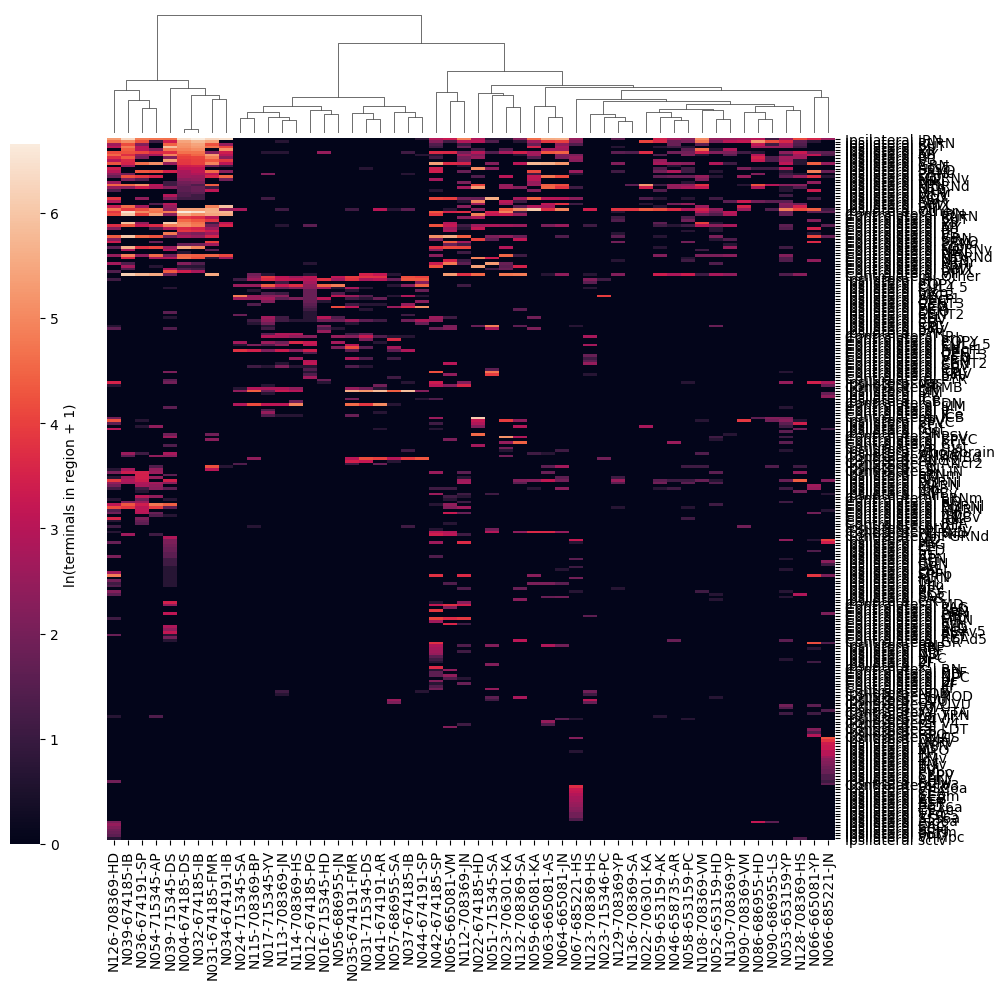

In [10]:
#hierarchical clustering on freq dataset
cmap_freq = cluster_and_plot(frequency_tocluster)
#cmap.plot()
#plt.show()

c:\Users\samkr\.local\share\mamba\envs\reconstructions\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


TypeError: Image data of dtype object cannot be converted to float

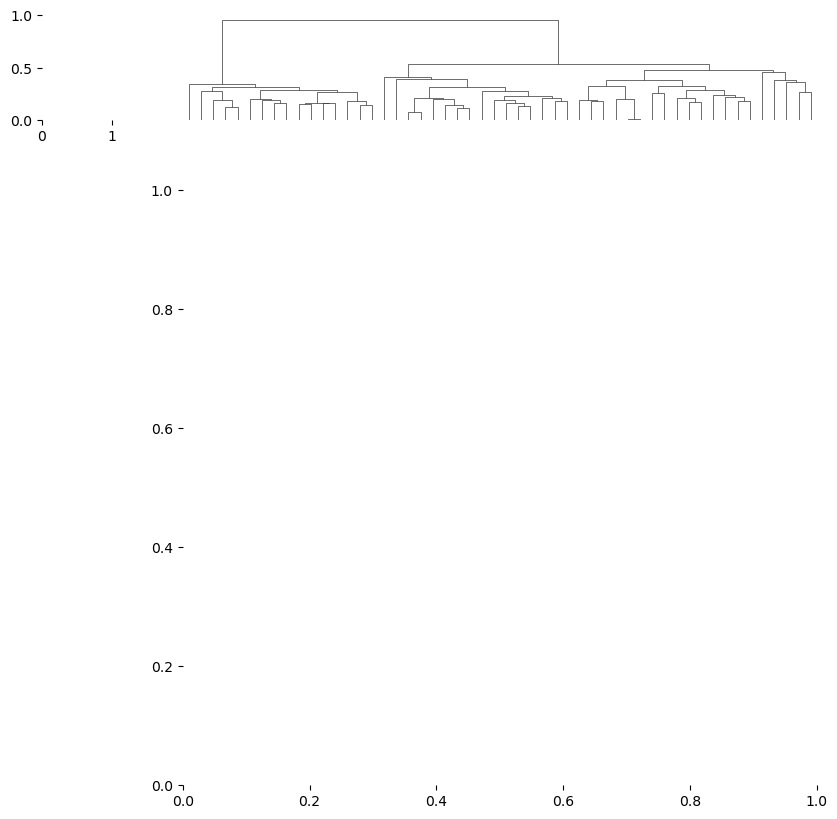

In [ ]:
#hierarchical clustering on the length dataset
#this is not working correctly atm for whatever reason, ill leave it be for now i think
#length_tocluster = length_tocluster.sort_index(axis=0)
#cmap_length = cluster_and_plot(length_tocluster)
sns.clustermap(length_tocluster, 
                method='ward', 
                metric='euclidean', 
                row_cluster=False,
                dendrogram_ratio=(.1, .15),
                cbar_pos=(0, .15, .03, .7),
                cbar_kws={'label': 'ln(terminals in region + 1)'},
                yticklabels=True,
                xticklabels=True)

In [35]:
help(cmap)

Help on ClusterGrid in module seaborn.matrix object:

class ClusterGrid(seaborn.axisgrid.Grid)
 |  ClusterGrid(data, pivot_kws=None, z_score=None, standard_scale=None, figsize=None, row_colors=None, col_colors=None, mask=None, dendrogram_ratio=None, colors_ratio=None, cbar_pos=None)
 |  
 |  Method resolution order:
 |      ClusterGrid
 |      seaborn.axisgrid.Grid
 |      seaborn.axisgrid._BaseGrid
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data, pivot_kws=None, z_score=None, standard_scale=None, figsize=None, row_colors=None, col_colors=None, mask=None, dendrogram_ratio=None, colors_ratio=None, cbar_pos=None)
 |      Grid object for organizing clustered heatmap input on to axes
 |  
 |  dim_ratios(self, colors, dendrogram_ratio, colors_ratio)
 |      Get the proportions of the figure taken up by each axes.
 |  
 |  format_data(self, data, pivot_kws, z_score=None, standard_scale=None)
 |      Extract variables from data or use directly.
 |  
 |  plo